In [4]:
!pip install -r requirements.txt

  Using cached baidu_aip-4.16.3-py3-none-any.whl (23 kB)
  Using cached bs4-0.0.1-py3-none-any.whl
  Using cached python_magic-0.4.26-py2.py3-none-any.whl (13 kB)
  Using cached furl-2.1.3-py2.py3-none-any.whl (20 kB)
  Using cached tendo-0.2.15-py2.py3-none-any.whl (23 kB)
  Using cached onnx-1.11.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (12.8 MB)
  Using cached sklite-0.0.2-py3-none-any.whl (11 kB)
  Using cached typing_extensions-3.10.0.2-py3-none-any.whl (26 kB)
  Using cached absl_py-0.15.0-py3-none-any.whl (132 kB)
  Using cached wrapt-1.12.1.tar.gz (27 kB)
  Preparing metadata (setup.py) ... done
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77040 sha256=076f51329f20cfca2d3c758d172b752c1d5a1bf4a7807293c549f7fd2a1cbad1
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869

In [5]:
import numpy as np
import pandas as pd
from keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
from tool import wine_data_loader, tflite_converter
import cfg
import tensorflow as tf
from keras import metrics

# Test your models

## data split

In [6]:
x_all_pre, y_all_pre = wine_data_loader.get_data3()
x_all_augmented, y_all_augmented = (x_all_pre, y_all_pre)
x, y, x_test, y_test = wine_data_loader.split(x_all_augmented, y_all_augmented)

In [7]:
# x_all_pre, y_all_pre = wine_data_loader.get_data3()
# x_all_augmented, y_all_augmented = (x_all_pre, y_all_pre)
# x, y  = x_all_augmented, y_all_augmented

## model builder

In [8]:


def build_model(act,kernel_count,drop_out_rate,loop_count,pool_size,strides,kernel_size,lr):
    print('params','act',act,'kernel_count',kernel_count,'drop_out_rate',drop_out_rate,'loop_count',loop_count,'pool_size',pool_size,'strides',strides,'kernel_size',kernel_size,'lr',lr)
    # pool_size = 1
    # strides = (1,)
    # act = 'tanh'
    # kernel_count = 12
    # drop_out_rate = .2

    inp = __next = layers.Input(shape=[1000], name='input')
    __next = layers.BatchNormalization()(__next)

    __next = layers.Reshape(target_shape=[1000,1])(__next)

    for i in range(loop_count):
        __next = layers.MaxPool1D(pool_size=pool_size, strides=pool_size, )(__next)
        __next = layers.Conv1D(filters=kernel_count, kernel_size=kernel_size, activation=act, )(__next)

    # __next = layers.Dense(800, activation=act)(__next)
    __next = layers.Reshape(target_shape=[-1])(__next)

    # __next = layers.Dense(100, activation=act)(__next)
    
    __next = layers.Dense(cfg.classify_count, activation=act)(__next)
    __next = layers.Dense(cfg.classify_count, activation=act)(__next)
    output = __next = layers.Dense(cfg.classify_count, activation='softmax')(__next)
    model = keras.Model(inputs=[inp], outputs=[output])

    opt = tf.keras.optimizers.Adam(lr=lr)

    # model.summary()
    # ,metrics= [metrics.categorical_accuracy]
    model.compile(
        optimizer=opt,
        # optimizer='adam',
        loss='categorical_crossentropy',
        # loss='mse',
        # metric s=['val_mse']
        metrics=['categorical_accuracy']
    )
    return model


import random
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)


In [9]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model) 

# act,kernel_count,drop_out_rate,loop_count,pool_size,strides,kernel_size
# param_distribs = {
#     'act' : ['relu','tanh','sigmoid'],
#     'kernel_count' : np.random.randint(low=1, high=20, size=10),
#     'drop_out_rate' : np.random.uniform(low=0.0, high=0.5, size=10),
#     'loop_count' : np.random.randint(low=1, high=10, size=10),
#     'pool_size' : [*np.random.randint(low=1, high=10, size=10),*np.random.randint(low=10, high=100, size=10),*np.random.randint(low=100, high=1000, size=10)],
#     'strides' : [*np.random.randint(low=1, high=10, size=10),*np.random.randint(low=10, high=100, size=10),*np.random.randint(low=100, high=1000, size=10)],
#     'kernel_size' : [*np.random.randint(low=1, high=20, size=10),*np.random.randint(low=20, high=100, size=10)],
#     'lr': reciprocal(1e-10, 1e-2),
# }

param_distribs = {
    'act' : ['relu','tanh','sigmoid'],
    'kernel_count' : [i for i in range(20)],
    'drop_out_rate' : [0.1,0.2,0.3],
    'loop_count' : [i for i in range(5)],
    'pool_size' : [*[i for i in range(10)],*[i for i in range(100,1000,100)]],
    'strides' : range(10),
    'kernel_size' : [1,3,7,15,30,60,100],
    'lr': [1e-2,1e-3,1e-4,1e-5],
}
# param_distribs

In [10]:

rnd_search_cv = GridSearchCV(keras_reg, param_distribs)
# rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5, cv=2)

rnd_search_cv.fit(x, y, epochs=20,
                #   validation_data=(x_test, y_test),
                  callbacks=[keras.callbacks.EarlyStopping(patience=50)]) 


KeyboardInterrupt: 

In [ ]:
rnd_search_cv.best_params_,rnd_search_cv.best_score_,

({'act': 'tanh',
  'drop_out_rate': 0.3,
  'kernel_count': 15,
  'kernel_size': 15,
  'loop_count': 2,
  'lr': 1.51947790839551e-08,
  'pool_size': 7,
  'strides': 3},
 -3.288481593132019)

## get best params

In [11]:
model = build_model(**{'act': 'tanh',
  'drop_out_rate': 0.3,
  'kernel_count': 18,
  'kernel_size': 3,
  'loop_count': 2,
  'lr': 0.001,
  'pool_size': 5,
  'strides': 1})
# model.summary()

params act tanh kernel_count 18 drop_out_rate 0.3 loop_count 2 pool_size 5 strides 1 kernel_size 3 lr 0.001


2022-06-04 05:45:06.738943: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:

history = model.fit(x, y, epochs=200,validation_data=(x_test, y_test))


2022-06-04 05:45:07.611685: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
19/19 [==============================] - 4s 42ms/step - loss: 2.4473 - categorical_accuracy: 0.1740 - val_loss: 2.6018 - val_categorical_accuracy: 0.1486
Epoch 2/200
19/19 [==============================] - 0s 12ms/step - loss: 2.2030 - categorical_accuracy: 0.3057 - val_loss: 2.3129 - val_categorical_accuracy: 0.3649
Epoch 3/200
19/19 [==============================] - 0s 9ms/step - loss: 2.0708 - categorical_accuracy: 0.3885 - val_loss: 2.1033 - val_categorical_accuracy: 0.2703
Epoch 4/200
19/19 [==============================] - 0s 9ms/step - loss: 1.9496 - categorical_accuracy: 0.4358 - val_loss: 1.9624 - val_categorical_accuracy: 0.3716
Epoch 5/200
19/19 [==============================] - 0s 13ms/step - loss: 1.8519 - categorical_accuracy: 0.4949 - val_loss: 1.7852 - val_categorical_accuracy: 0.4730
Epoch 6/200
19/19 [==============================] - 0s 9ms/step - loss: 1.8524 - categorical_accuracy: 0.4155 - val_loss: 1.7100 - val_categorical_accuracy: 0.6216
Epoch 7

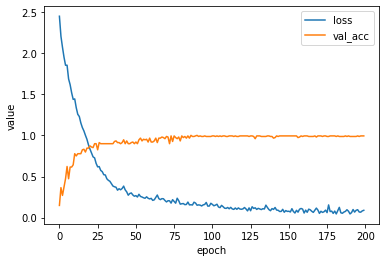

In [13]:

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_categorical_accuracy'],label='val_acc')


# for k in history.history.keys():
#     plt.plot(history.history[k],label=k)

plt.xlabel('epoch')
plt.ylabel('value') 

plt.legend()
plt.show()

In [14]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

## play your trained model

In [15]:
predict_y = model.predict(x_test)

In [16]:
prediction_targets = predict_y.argmax(axis=1)

In [17]:
y_test_targets = y_test.argmax(axis =1)

In [18]:
correct_matrix = (prediction_targets == y_test_targets)
sum(correct_matrix)/len(correct_matrix)

0.9932432432432432

array([[ 8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 14,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 13,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 13,  0],
       [ 0,  0,  0,  0,  0,  0,  0

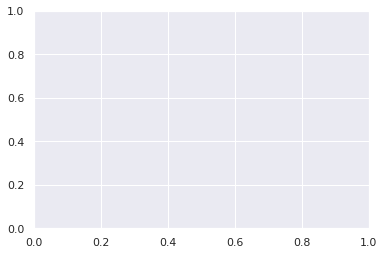

In [34]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()

y_test = y_test_targets
y_pred = prediction_targets


fig = plt.figure()
ax = fig.add_subplot(111)
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

In [35]:
import torch

In [36]:

# softmax at axis=1
conf_mat = torch.nn.Softmax(dim=1)(torch.tensor(conf_mat).type(torch.FloatTensor)).numpy()
conf_mat

array([[9.9532557e-01, 3.3389454e-04, 3.3389454e-04, 3.3389454e-04,
        3.3389454e-04, 3.3389454e-04, 3.3389454e-04, 3.3389454e-04,
        3.3389454e-04, 3.3389454e-04, 3.3389454e-04, 3.3389454e-04,
        3.3389454e-04, 3.3389454e-04, 3.3389454e-04],
       [3.0590101e-07, 9.9999571e-01, 3.0590101e-07, 3.0590101e-07,
        3.0590101e-07, 3.0590101e-07, 3.0590101e-07, 3.0590101e-07,
        3.0590101e-07, 3.0590101e-07, 3.0590101e-07, 3.0590101e-07,
        3.0590101e-07, 3.0590101e-07, 3.0590101e-07],
       [1.4221429e-02, 1.4221429e-02, 7.7646369e-01, 1.4221429e-02,
        1.4221429e-02, 1.4221429e-02, 1.4221429e-02, 1.4221429e-02,
        1.4221429e-02, 1.4221429e-02, 3.8657848e-02, 1.4221429e-02,
        1.4221429e-02, 1.4221429e-02, 1.4221429e-02],
       [1.2319698e-04, 1.2319698e-04, 1.2319698e-04, 9.9827552e-01,
        1.2319698e-04, 1.2319698e-04, 1.2319698e-04, 1.2319698e-04,
        1.2319698e-04, 1.2319698e-04, 1.2319698e-04, 1.2319698e-04,
        1.2319698e-04,

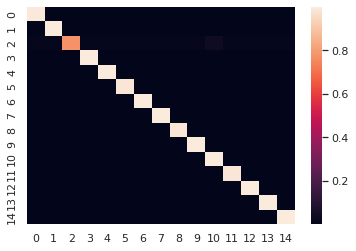

In [38]:

# sns.heatmap(conf_mat,annot=True) #画热力图
sns.heatmap(conf_mat,) #画热力图
ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴
plt.show()